# Analysing Air Quality Features and Predicting PM2.5 Level

## List Authors
* Zehao Jiang
* Shuai Liu
* Haonan Chen

## Abstract

We obtain this dataset from UCI datasets. This dataset includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring site. We first performed data cleaning, EDA, feature engeneering to fully explore the data. Then we use multiple methods trying to predict PM2.5 level using other features. We made comparison between different methods and discussed what we can do to further improve in the future.

## Introduction

A vast part of China is experiencing chronic air pollution with severe fine particulate matter(PM) concentration and PM2.5 in particular. PM2.5 is the fine PM with diameter of less than 2.5 μm which leads to great harm to human bodies. 

In this study, we conducted analyses on different air quality features and tried to find the relationship between PM2.5 and other air quality variables. 

First, we took a look to the data itself and clean it for future analysis. By EDA, we visually found out a lot of information about the variables and had a rough understanding of their relationship. By conducting feature engeneering, we dropped some redundant features and successfully convert time feature to make more sence in our future predicting.

We used linear regression, KNN and random forest to predict PM2.5 level using other variables. We compared their performance and computational efficiency.

At last, we looked back at our study and made some conclusions. Of course there are still works we could do in the future and we would like to explore deeper into this data.

## Description of Data

This data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017. Missing data are denoted as NA.

## 0. Setup

In [1]:
import pandas as pd
import os
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
import time
import sklearn.model_selection
from sklearn.model_selection import KFold
import sklearn.linear_model as lm
from sklearn.neighbors  import KNeighborsRegressor
from sklearn import tree
from sklearn import ensemble
from sklearn import preprocessing

import warnings

warnings.filterwarnings('ignore')

## 1. Loading Data Sets
We have several data sets where each one contains the data collected by distinct station, for the convenience of analyzing, we want to load them and concatenate them into a single data set

In [2]:
files = os.walk('.')
cnt = 0
for f in files:
    for c in f[2]:
        search_rst = re.search('\.csv', c, re.M|re.I)
        if(search_rst):
            if(cnt == 0):
                tab = pd.read_csv(c)
                cnt = cnt+1
            else:
                tab = pd.concat([tab, pd.read_csv(c)])
air_quality = tab
air_quality.shape

(420768, 18)

In [3]:
air_quality.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


In [4]:
air_quality.tail()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
35059,35060,2017,2,28,19,27.0,72.0,8.0,92.0,800.0,16.0,10.3,1014.2,-12.4,0.0,W,1.8,Shunyi
35060,35061,2017,2,28,20,47.0,55.0,17.0,86.0,1100.0,19.0,9.8,1014.5,-9.9,0.0,NW,1.5,Shunyi
35061,35062,2017,2,28,21,18.0,28.0,4.0,30.0,500.0,64.0,9.1,1014.6,-12.7,0.0,NE,1.7,Shunyi
35062,35063,2017,2,28,22,18.0,20.0,9.0,33.0,500.0,59.0,7.1,1015.2,-13.2,0.0,WNW,1.8,Shunyi
35063,35064,2017,2,28,23,15.0,22.0,13.0,34.0,500.0,60.0,7.4,1014.9,-11.9,0.0,N,1.4,Shunyi


## 2. Data Cleaning
### 2.1 Unboxing the data
+ The data contains 420,768 records with 18 features
+ The data is encoded in plain text
+ The format of the data is aligned fields separated by commas  

### 2.2 Identifying granularity
+ It is rectangular data
+ The granularity of the data is the air quality index of an hour(ranging from 0 to 12)in a day(ranging from 2013-03-01 to 2017-02-28) measured by one of the meteorological stations in Beijing  

### 2.3 Check Quality and Clean
#### 2.3.1 Dropping Useless Attributes
It turns out that there is a linear relation between *PM10* and *PM2.5* and we would like to discover a novel relationship between *PM2.5* and other air quality indices, so the attribute *PM10* is dropped.

Since the number of records cannot really help us make predictions, the attribute *No* is dropped.  

In [5]:
air_quality.drop('PM10', axis=1, inplace=True)

In [6]:
air_quality.drop('No', axis = 1, inplace = True)

In [7]:
air_quality.shape

(420768, 16)

#### 2.3.2 Dealing with missing values
To deal with missing values, the first thing we'd like to do is to observe how many data in each column are missing:

In [8]:
print('Missing value number per column:')
for c in air_quality.columns:
    print(c+': '+str(sum(air_quality[c].isnull())))

Missing value number per column:
year: 0
month: 0
day: 0
hour: 0
PM2.5: 8739
SO2: 9021
NO2: 12116
CO: 20701
O3: 13277
TEMP: 398
PRES: 393
DEWP: 403
RAIN: 390
wd: 1822
WSPM: 318
station: 0


It can be observed that there are not many missing values compared to the size of the whole data set.

We fullfill the missing numeric values with the average of the first previous non-null value and the first successive non-null value since the table is ordered by date.
There is only one categorical missing values: 'wd'. We impute the missing values with the previous observed non-null value.

In [9]:
air_quality['wd'].ffill(inplace = True)

In [10]:
for c in air_quality.columns:
    if(c!='wd' and sum(air_quality[c].isnull())!=0):
        f = air_quality[c].ffill()
        b = air_quality[c].bfill()
        air_quality[c] = (f+b)/2
air_quality['NO2'].bfill(inplace=True)

In [11]:
air_quality.head()

,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,6.0,5.0,5.0,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2013,3,1,1,6.0,5.0,5.0,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,2013,3,1,2,5.0,5.5,5.0,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,2013,3,1,3,6.0,6.0,5.0,650.0,62.5,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,2013,3,1,4,5.0,5.0,5.0,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


In [12]:
air_quality.isnull().values.any()

False

## 3. EDA
Due to the fact that the original data set is too large, we construct three data sets to help us to perform EDA:
1. `average` the average of numeric values of each month in each year.
2. `month_average` the average of numeric values of each month in the whole 5 years
3. `hour_average` the average of numeric values of each hour over in the whole 5 years


In [13]:
year_month = air_quality.groupby(['year', 'month']).size().index
cnt = 0
for y,m in year_month:
    y_m = air_quality[air_quality['year'] == y][:]
    y_m = y_m[y_m['month'] == m][:]
    #print(y_m.shape)
    value_mean = y_m.mean(axis = 0 ).to_frame().T
    value_mean['year_month'] = datetime.date(y,m,1)
    value_mean['year'] = y
    value_mean['month'] = m
    if(cnt == 0):
        cnt = cnt+1
        average = value_mean
    else:
        average = pd.concat([average, value_mean], axis = 0)
average.head()

,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,year_month
0,2013,3,16.0,11.5,104.571909,38.530270,67.233125,1449.916555,56.343421,5.992249,1012.224373,-6.682090,0.023768,1.886414,2013-03-01
0,2013,4,15.5,11.5,62.223090,20.692168,46.152132,893.616840,62.021103,12.380058,1007.811817,-3.203681,0.014294,2.333310,2013-04-01
0,2013,5,16.0,11.5,81.861223,26.371710,50.151548,999.470206,87.334326,21.676691,1002.652912,8.131384,0.005791,1.811694,2013-05-01
0,2013,6,15.5,11.5,101.519387,13.607179,48.111850,1337.126157,74.325269,23.583426,999.639838,17.440023,0.126528,1.287350,2013-06-01
0,2013,7,16.0,11.5,66.861783,7.278896,38.682645,981.243168,78.585536,27.108826,995.501680,20.902184,0.275448,1.316913,2013-07-01


In [14]:
cnt = 0
for m in air_quality['month'].unique():
    mean_value = air_quality[air_quality['month'] == m].mean().to_frame().T
    mean_value['month'] = m
    if(cnt == 0):
        cnt = cnt+1
        month_average = mean_value
    else:
        month_average = pd.concat([month_average, mean_value])
month_average.drop(['year', 'day', 'hour'], inplace = True, axis = 1)
month_average.head()

,month,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,3,94.594295,27.960784,59.954302,1310.173191,50.748473,8.348466,1013.957213,-7.945209,0.007586,1.976319
0,4,73.371102,14.225151,47.744151,838.265321,70.216371,15.328909,1008.307401,0.187078,0.022885,2.173886
0,5,63.526771,14.581895,42.688745,808.511705,92.466724,21.481823,1002.394436,6.877117,0.045873,2.065579
0,6,68.842740,7.903155,39.135095,982.852141,94.899390,24.554861,999.335043,15.614013,0.132986,1.576930
0,7,71.406645,5.523216,35.652777,905.532846,96.330024,27.194170,998.131404,19.920511,0.267686,1.497536


In [15]:
cnt = 0
for h in air_quality['hour'].unique():
    mean_value = air_quality[air_quality['hour'] == h].mean().to_frame().T
    mean_value['hour'] = h
    if(cnt == 0):
        cnt = cnt+1
        hour_average = mean_value
    else:
        hour_average = pd.concat([hour_average, mean_value])
hour_average.drop(['year', 'month', 'day'], inplace = True, axis = 1)
hour_average.head()

,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,0,87.684001,15.137417,57.844899,1376.215121,42.044920,11.282272,1011.171887,3.138544,0.068138,1.357729
0,1,86.836550,15.153322,55.675716,1377.549139,38.380160,10.816528,1011.110165,3.171926,0.052647,1.321957
0,2,84.792739,14.920399,53.297104,1325.655373,34.556189,10.364587,1011.058371,3.113487,0.066159,1.282389
0,3,82.218674,13.744183,52.239663,1277.181554,32.330076,9.966964,1010.992418,3.026015,0.093401,1.257449
0,4,79.501078,13.255369,51.620937,1247.176762,30.759641,9.640377,1010.992588,2.903528,0.069479,1.234851


### 3.1 Understanding the relationship between time and PM2.5 level
Examine PM2.5 level by plotting the average PM2.5 level over the entire data set with x-axis being year-month, month, hour.

Text(0.5, 1.0, 'Figure3.1.1 Year-Month average PM2.5 Level')

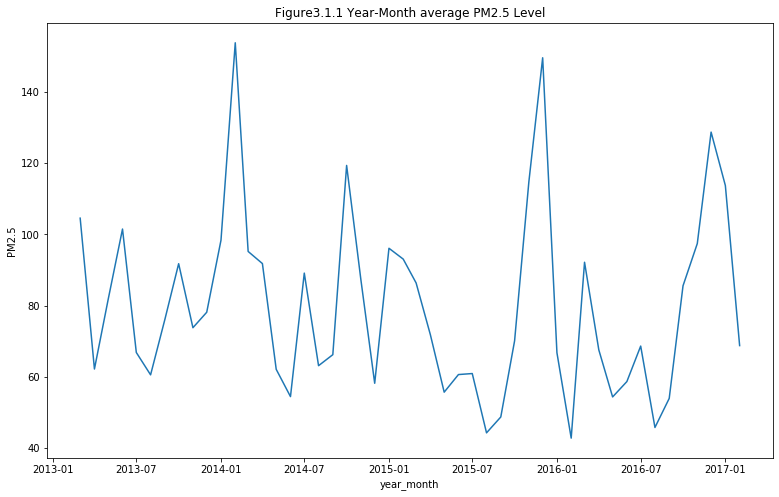

In [16]:
plt.figure(figsize = (13,8))
sns.lineplot(x = 'year_month', y = 'PM2.5', data = average)
plt.title('Figure3.1.1 Year-Month average PM2.5 Level')

Text(0.5, 1.0, 'Figure3.1.2 Month average PM2.5 Level')

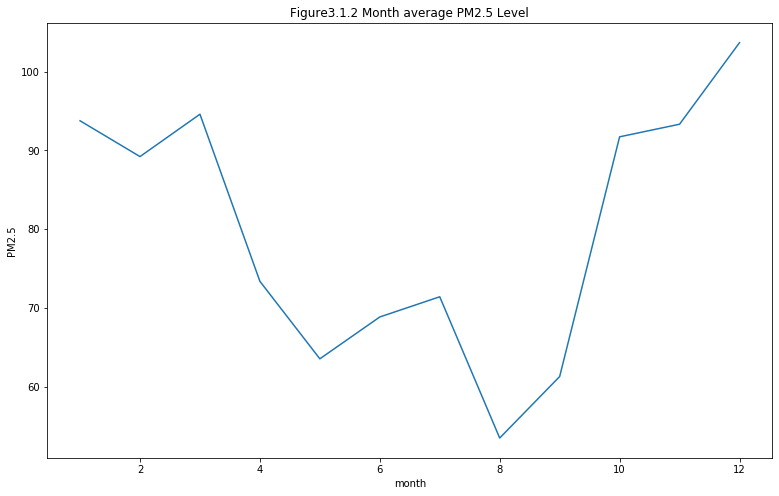

In [17]:
plt.figure(figsize = (13,8))
sns.lineplot(x = 'month', y = 'PM2.5', data = month_average)
plt.title('Figure3.1.2 Month average PM2.5 Level')

Text(0.5, 1.0, 'Figure3.1.3 Hour average PM2.5 Level')

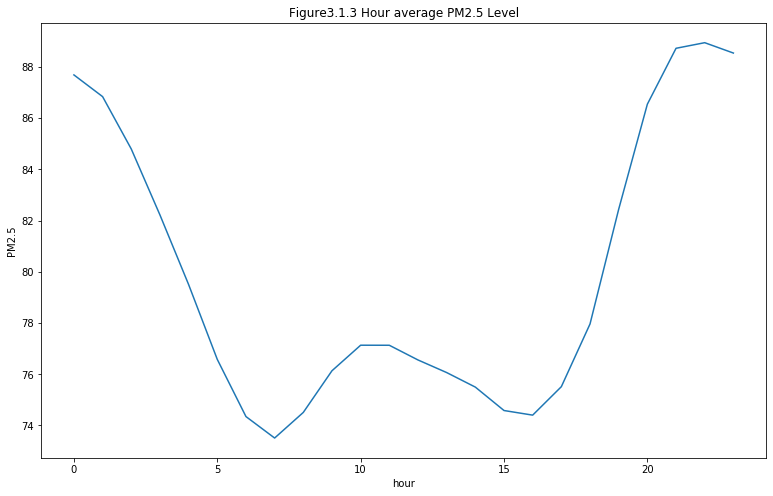

In [18]:
plt.figure(figsize = (13, 8))
sns.lineplot(x = 'hour', y = 'PM2.5', data = hour_average)
plt.title('Figure3.1.3 Hour average PM2.5 Level')

There are some interesting things that can be observed from the plot:

1. The PM2.5 level of summer is obviously lower than that of winter. It may because people have to use heaters in winter which works mainly by burning coal, which makes the air quality worse.


2. The PM2.5 level increases from May to July then decreases in August. Empirically, it is because the rainy season begins in June and ends in August.


3. The PM2.5 level changes a lot during the 24 hours of a day. It reaches its peak on 11 PM and the lowest value is achieved on 6 AM.

### 3.2 Data Preparation
Use 0 to 15 to represent wind direction and add two attributes: the latitude and longitude of the station

In [19]:
wind_partition = {'E':0, 'ENE':1, 'NE':2,'NNE':3, 'N':4, 'NNW':5, 'NW':6, 'WNW':7, 'W':8, 
                  'WSW':9, 'SW':10, 'SSW':11, 'S':12, 'SSE':13, 'SE':14,'ESE':15}
air_quality['wd_numeric'] = air_quality['wd'].agg(lambda x: wind_partition[x])
air_quality.head()

,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,wd_numeric
0,2013,3,1,0,6.0,5.0,5.0,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng,6
1,2013,3,1,1,6.0,5.0,5.0,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng,6
2,2013,3,1,2,5.0,5.5,5.0,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng,7
3,2013,3,1,3,6.0,6.0,5.0,650.0,62.5,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng,8
4,2013,3,1,4,5.0,5.0,5.0,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng,7


In [20]:
air_quality['station'].unique()
station_partition = {'Aotizhongxin':[39.985938, 116.393825]}
station_partition['Gucheng'] = [39.911589, 116.310204]
station_partition['Huairou'] = [40.358597, 116.633396]
station_partition['Tiantan'] = [39.882386, 116.406612]
station_partition['Changping'] = [40.227645, 116.218963]
station_partition['Guanyuan'] = [39.936087, 116.360962]
station_partition['Nongzhanguan'] = [39.943060, 116.461937]
station_partition['Wanliu'] = [39.988509, 116.295105]
station_partition['Dongsi'] = [39.928881, 116.422936]
station_partition['Wanshouxigong'] = [39.881856, 116.368982]
station_partition['Dingling'] = [40.296166, 116.223548]
station_partition['Shunyi'] = [40.128292, 116.621523]
air_quality['station_lon'] = air_quality['station'].agg(lambda x:station_partition[x][1])
air_quality['station_lat'] = air_quality['station'].agg(lambda x:station_partition[x][0])
air_quality.head()

,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,wd_numeric,station_lon,station_lat
0,2013,3,1,0,6.0,5.0,5.0,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng,6,116.310204,39.911589
1,2013,3,1,1,6.0,5.0,5.0,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng,6,116.310204,39.911589
2,2013,3,1,2,5.0,5.5,5.0,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng,7,116.310204,39.911589
3,2013,3,1,3,6.0,6.0,5.0,650.0,62.5,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng,8,116.310204,39.911589
4,2013,3,1,4,5.0,5.0,5.0,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng,7,116.310204,39.911589


### 3.3 Exploring the Relationship between Other Numerical Air Quality Indices and PM2.5
To apply transformations, we have to plot the raw data. However, our dataset is too large, so we decide to randomly sample some data which is representative of the original dataset to observe.

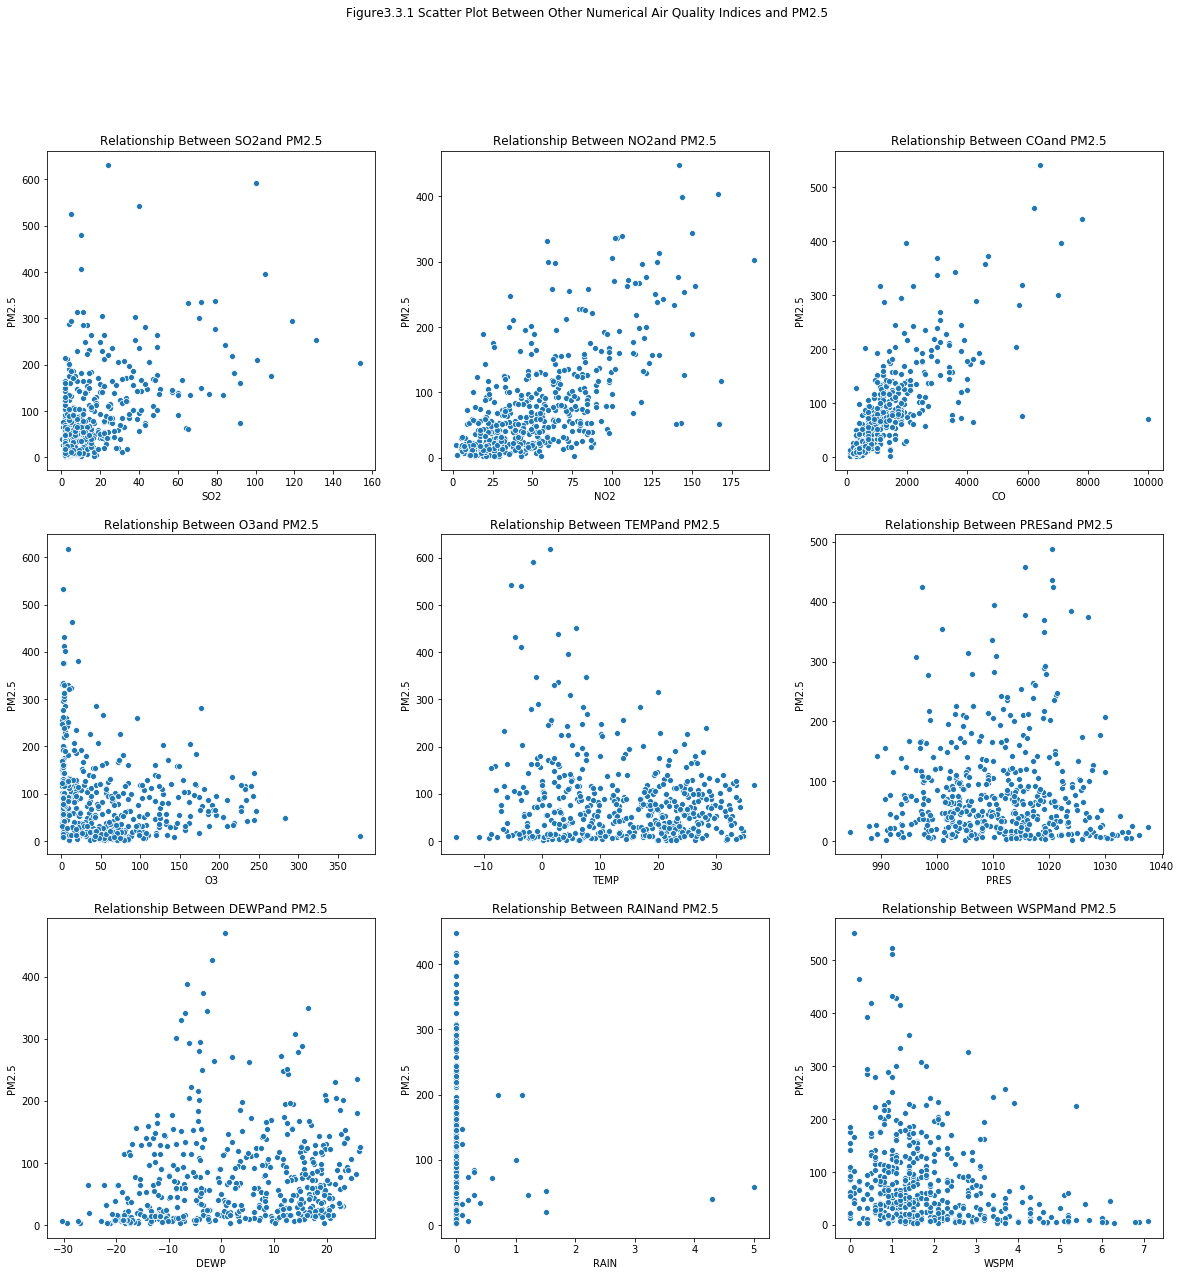

In [21]:
i = 1
plt.figure(figsize=(20,20))
for c in air_quality.iloc[:, 5:-4].drop('wd', axis = 1).columns:
    plt.subplot(3,3,i)
    i = i+1
    d = air_quality[:][[c, 'PM2.5']].dropna().sample(500)
    sns.scatterplot(data = d, x = c, y = 'PM2.5')
    plt.title('Relationship Between ' + str(c) + 'and PM2.5')
plt.suptitle('Figure3.3.1 Scatter Plot Between Other Numerical Air Quality Indices and PM2.5')
plt.show()

From the RAIN-PM2.5 plot, we can see that if there the weather is rainy, then it is very possible that the PM2.5 level will be low

#### 3.3.1 Discovering the Linear Relationship between PM2.5 and single Air Quality Index
From the nine plots above, CO and PM2.5, NO2 and PM2.5 are seemingly highly correlated  
So we calculate the correlation of these two attributes and PM2.5 over the entire data set to examine our hypothesis

In [22]:
def calculate_correlation(x,y):
    n = len(y)
    sigma_xy = sum((x - np.mean(x)) * (y - np.mean(y)))/n
    sigma_x = math.sqrt(np.var(x))
    sigma_y = math.sqrt(np.var(y))
    return sigma_xy/(sigma_x * sigma_y)
def get_correlation(att, func1=None, func2 = None):
    att_pm25 = air_quality[[att, 'PM2.5']].dropna()
    att = np.array(att_pm25[att])
    pm25 = np.array(att_pm25['PM2.5'])
    if(func1 == None and func2 == None):
        return calculate_correlation(pm25, att)
    elif(func2 == None):
        return calculate_correlation((pm25), func1(att))
    elif(func1 == None):
        return calculate_correlation(func2(pm25), (att))
    else:
        return calculate_correlation(func2(pm25), func1(att))

print('The correlation between NO2 and PM2.5 is: '+str(get_correlation('NO2')))
print('The correlation between CO and PM2.5 is: '+str(get_correlation('CO')))

The correlation between NO2 and PM2.5 is: 0.6637828103521851
The correlation between CO and PM2.5 is: 0.7806830350102302


By the correlation calculated above, we can conclude that there does exist an approximate linear relationship between PM2.5 and NO2/CO

### 3.3.2 Apply Transformations
By roughly observe the plots, we can try to apply transformations to O3-PM2.5, DEWP-PM2.5, WSPM-PM2.5 to get a linear relationship:

In [23]:
def plot_single(attr1, titlefunc1, titlefunc2, index, attr2='PM2.5', func1=None, func2=None, sample_size=1000, figs=[5,5]):
    att_pm25 = air_quality[[attr1, attr2]].dropna().sample(sample_size)
    att = np.array(att_pm25[attr1])
    pm25 = np.array(att_pm25[attr2])
#     plt.figure(figsize = (3 * figs[0],figs[1]))
    plt.subplot(1, 3, index)
    if(func1 == None and func2 == None):
        plt.scatter(att, pm25)
    elif(func2 == None):
        plt.scatter(func1(att), pm25, s = np.ones(pm25.shape))
    elif(func1 == None):
        plt.scatter(att, func2(pm25), s = np.ones(pm25.shape))
    else:
        plt.scatter(func1(att), func2(pm25), s =0.1*np.ones(pm25.shape))
    plt.xlabel(titlefunc1 + attr1)
    plt.ylabel(titlefunc2 + attr2)
    plt.title('Relationship between ' + titlefunc1 + attr1+' - '+ titlefunc2 + attr2)
#     plt.show()

Text(0.5, 0.98, 'Figure3.3.2 Scatter Plot after Applying Transformations')

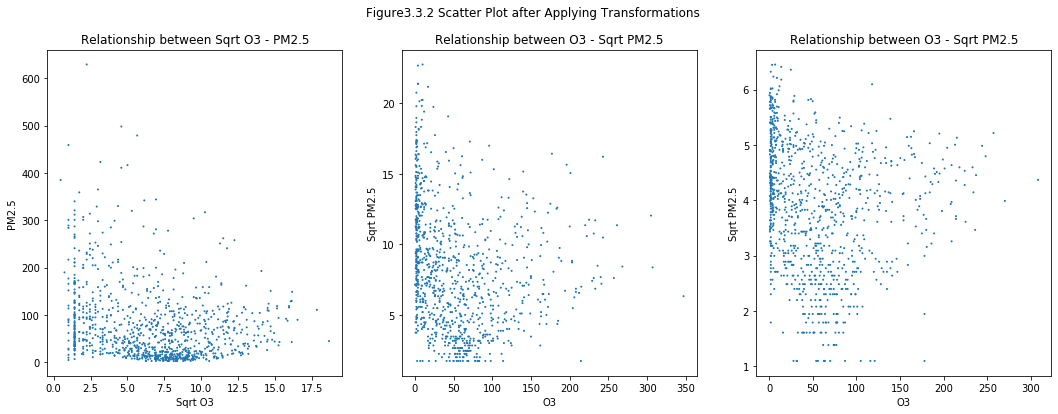

In [24]:
plt.figure(figsize = (18, 6))
plot_single('O3', func1=np.sqrt, titlefunc1 = 'Sqrt ', titlefunc2 = '', index=1)
plot_single('O3', func2 = np.sqrt, titlefunc1 = '', titlefunc2 = 'Sqrt ', index=2)
plot_single('O3', func2 = np.log, titlefunc1 = '', titlefunc2 = 'Sqrt ', index=3)
plt.suptitle('Figure3.3.2 Scatter Plot after Applying Transformations')

Text(0.5, 0.98, 'Figure3.3.3 Scatter Plot after Applying Transformations')

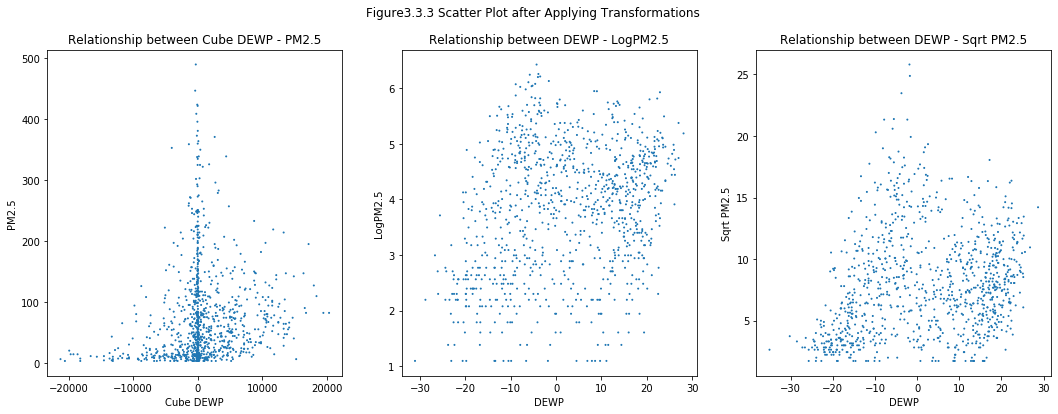

In [25]:
plt.figure(figsize = (18, 6))
plot_single('DEWP', func1=lambda x:x**3, titlefunc1 = 'Cube ', titlefunc2 = '', index=1)
plot_single('DEWP', func2 = np.log, titlefunc1 = '', titlefunc2 = 'Log', index=2)
plot_single('DEWP', func2=np.sqrt, titlefunc1 = '', titlefunc2 = 'Sqrt ', index=3)
plt.suptitle('Figure3.3.3 Scatter Plot after Applying Transformations')

Text(0.5, 0.98, 'Figure3.3.4 Scatter Plot after Applying Transformations')

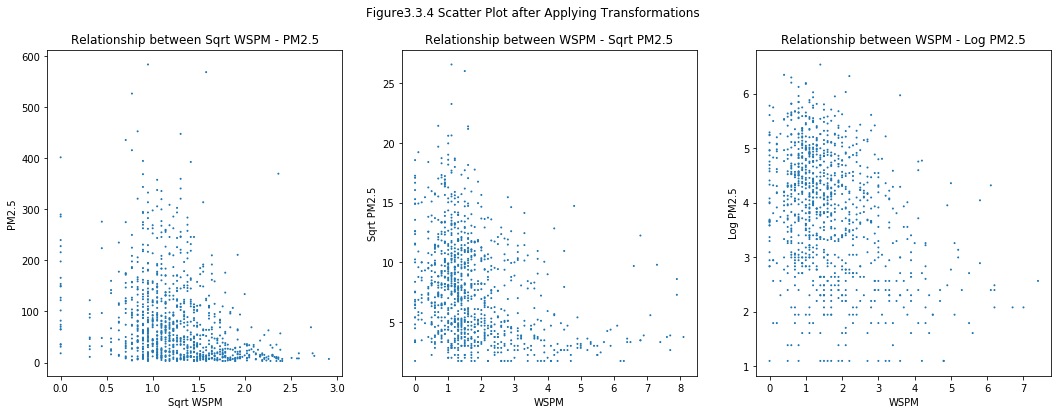

In [26]:
plt.figure(figsize = (18, 6))
plot_single('WSPM', func1=np.sqrt, titlefunc1 = 'Sqrt ', titlefunc2 = '', index=1)
plot_single('WSPM', func2 = np.sqrt, titlefunc1 = '', titlefunc2 = 'Sqrt ', index=2)
plot_single('WSPM', func2 = np.log, titlefunc1 = '', titlefunc2 = 'Log ', index=3)
plt.suptitle('Figure3.3.4 Scatter Plot after Applying Transformations')

From the plots above, we can conclude that no transformation can be applied to the data.

#### 3.3.3 Discovering the Relationship between PM2.5 and two Air Quality Indices
By plotting the scatterplot of two air quality index(except PM2.5) and letting the color of the dots denote PM2.5 level, we would like to find out some the relationship between PM2.5 and two Air Quality indices. Because our dataset is too large, we SRS a certain amount records to represent the entire dataset.  

In the plots below, red dots represent high PM2.5 level(>150), blue dots represent medium PM2.5 level(71 to 150), green dots represent low PM2.5 level(<70)

In [27]:
def plot_double(x_value, y_value, index1, index, x_lim=None, y_lim=None, figs=[12,10], sample_size = 3000, data=air_quality):
    plot_data = data[[x_value, y_value, 'PM2.5']].dropna().sample(sample_size)
    plt.figure(figsize = (figs[0],figs[1]))
    partition = [150 ,70, 0]
    for i in range(3):
        to_drop = plot_data[plot_data['PM2.5']>partition[i]].index
        pm_25 = np.array(plot_data[plot_data['PM2.5']>partition[i]]['PM2.5'])
        x = np.array(plot_data[plot_data['PM2.5']>partition[i]][x_value])
        y = np.array(plot_data[plot_data['PM2.5']>partition[i]][y_value])
        plot_data.drop(to_drop, inplace = True)
        m = max(pm_25)
        if(i == 0):
            color = np.c_[pm_25/m, np.zeros(pm_25.shape), np.zeros(pm_25.shape)/m]
        elif(i == 2):
            color = np.c_[np.zeros(pm_25.shape),pm_25/m,np.zeros(pm_25.shape)]
        else:
            color = np.c_[np.zeros(pm_25.shape),np.zeros(pm_25.shape),pm_25/m]

        plt.scatter(x, y, c = color, s = 1*np.ones(x.shape))
    plt.xlabel(x_value)
    plt.ylabel(y_value)
    if(x_lim != None and y_lim != None):
        plt.xlim(x_lim[0], x_lim[1])
        plt.ylim(y_lim[0], y_lim[1])
    elif(x_lim == None and y_lim != None):
        plt.ylim(y_lim[0], y_lim[1])
    elif(y_lim == None and x_lim!= None):
        plt.xlim(x_lim[0], x_lim[1])
    plt.title('Figure3.' + str(index1) + '.' + str(index) + ' Relationship between ' + x_value+' and '+y_value)
    plt.show()

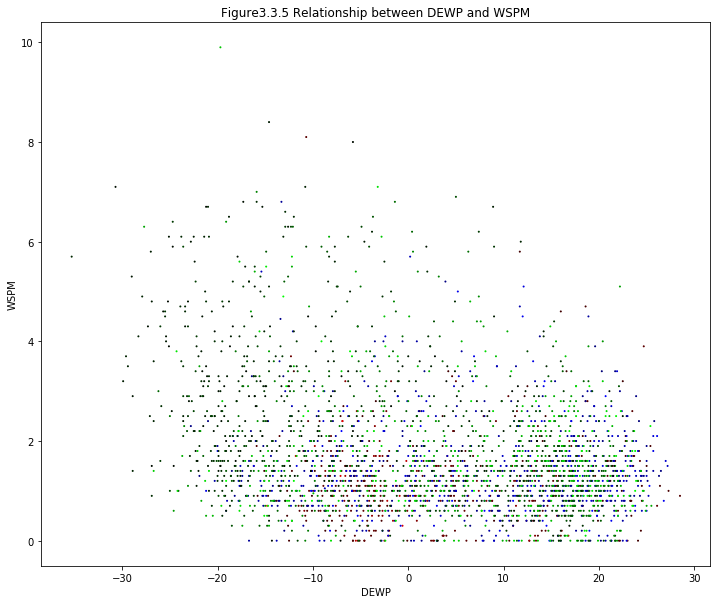

In [28]:
plot_double('DEWP', 'WSPM', 3, 5)

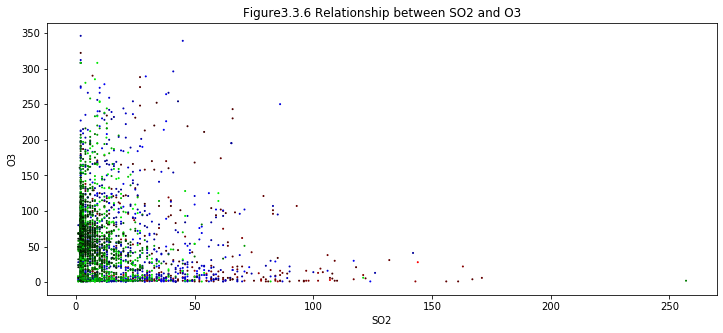

In [29]:
plot_double('SO2', 'O3', 3, 6, figs=[12,5], sample_size=3000)

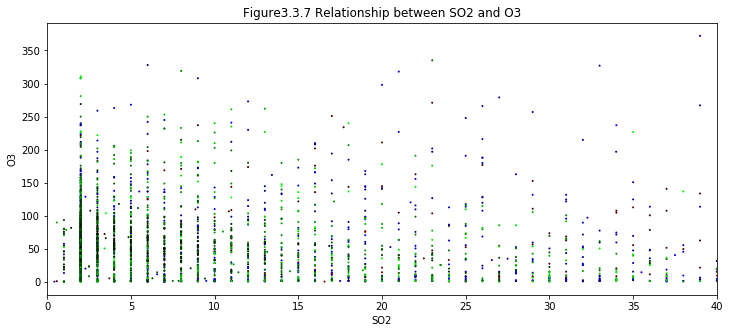

In [30]:
plot_double('SO2', 'O3', 3, 7, x_lim=[0,40],figs=[12,5])

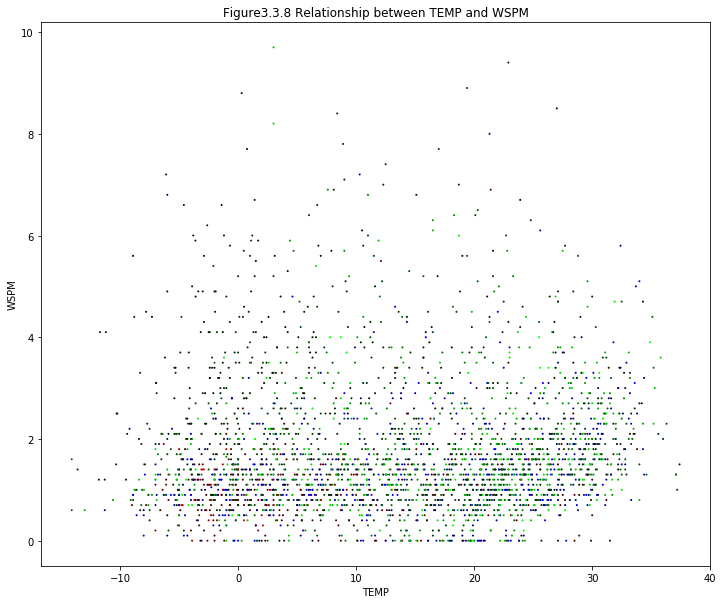

In [31]:
plot_double('TEMP', 'WSPM', 3, 8)

From the plots above, we can see that:

1. With low wind speed and relative dry environment, PM2.5 level tend to be high.


2. With a high level of SO2 in the atmosphere, a high PM2.5 level tends to appear along with a high O3 level.  


3. With low wind speed and low temperature, PM2.5 level tend to be higher.

### 3.4 Exploring the Relationship between Categorical Attributes and PM2.5
There are two categorical attributes other than time in the dataset: `station` and `wd`, we will explore them one by one.
#### 3.4.1 station
Since the data are observed from different sites, we want to see the PM2.5 distribution in each area. We take longitude as x-axis, latitude as y-axis, each observation site are denoted as up traingles. Then we sample 3000 data points and add a random Gaussian noise :$noise \sim N(0,1.2)$ to them to see the distribution of the noised data we sampled.

Text(0.5, 0.98, 'Figure3.4.1 Scatter Plot with Different PM2.5 Level')

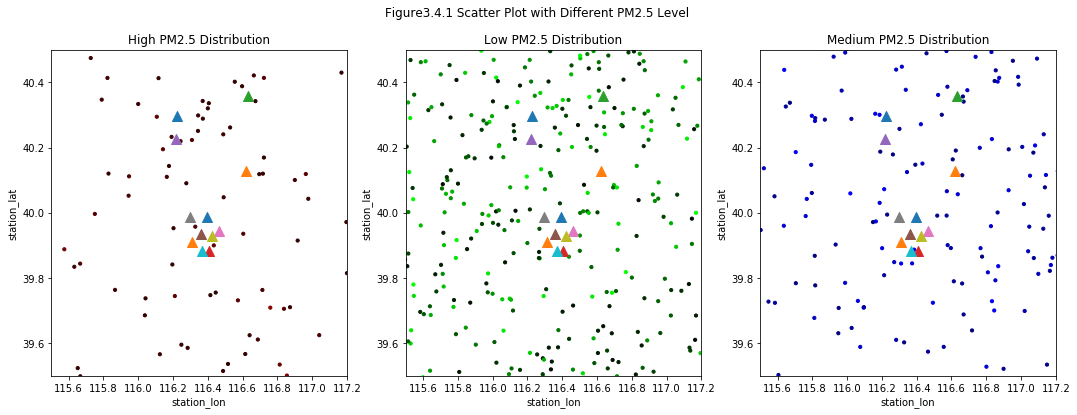

In [32]:
y_value = 'station_lat'
x_value = 'station_lon'
plot_data = air_quality[[x_value, y_value, 'PM2.5']].dropna().sample(3000)
plot_data[x_value] = plot_data[x_value] + np.random.normal(0, 1.2, 3000)
plot_data[y_value] = plot_data[y_value] + np.random.normal(0, 1.2, 3000)
plt.figure(figsize = (18,6))
partition = [150, 70, 0]
for i in range(3):
    to_drop = plot_data[plot_data['PM2.5']>partition[i]].index
    pm_25 = np.array(plot_data[plot_data['PM2.5']>partition[i]]['PM2.5'])
    x = np.array(plot_data[plot_data['PM2.5']>partition[i]][x_value])
    y = np.array(plot_data[plot_data['PM2.5']>partition[i]][y_value])
    plot_data.drop(to_drop, inplace = True)
    m = max(pm_25)
    if(i == 0):
        plt.subplot(1,3,1)
        color = np.c_[pm_25/m, np.zeros(pm_25.shape), np.zeros(pm_25.shape)/m]
        plt.scatter(x, y, c = color, s = 10*np.ones(x.shape))
        for e in station_partition.keys():
            plt.scatter(station_partition[e][1], station_partition[e][0],marker='^', s = [100] )
        plt.ylim(39.5, 40.5)
        plt.xlim(115.5, 117.2)
        plt.xlabel(x_value)
        plt.ylabel(y_value)
        plt.title('High PM2.5 Distribution')
    elif(i == 2):
        plt.subplot(1,3,2)
        color = np.c_[np.zeros(pm_25.shape),pm_25/m,np.zeros(pm_25.shape)]
        plt.scatter(x, y, c = color, s = 10*np.ones(x.shape))
        for e in station_partition.keys():
            plt.scatter(station_partition[e][1], station_partition[e][0],marker='^', s = [100] )
        plt.ylim(39.5, 40.5)
        plt.xlim(115.5, 117.2)
        plt.xlabel(x_value)
        plt.ylabel(y_value)
        plt.title('Low PM2.5 Distribution')

    else:
        plt.subplot(1,3,3)
        color = np.c_[np.zeros(pm_25.shape),np.zeros(pm_25.shape),pm_25/m]
        plt.scatter(x, y, c = color, s = 10*np.ones(x.shape))
        for e in station_partition.keys():
            plt.scatter(station_partition[e][1], station_partition[e][0],marker='^', s = [100] )
        plt.ylim(39.5, 40.5)
        plt.xlim(115.5, 117.2)
        plt.xlabel(x_value)
        plt.ylabel(y_value)
        plt.title('Medium PM2.5 Distribution')
plt.suptitle('Figure3.4.1 Scatter Plot with Different PM2.5 Level')

From the plots above, we found out that the PM2.5 level of the upper right corner of Beijing is relatively low since the red dots which represent high PM2.5 records are relatively sparse and green dots which represent low PM2.5 records are relatively dense.
Similarly, the PM2.5 level of the lower left corner of Beijing is relatively high

#### 3.4.2 wd
To observe the relationship between PM2.5 level and wind direction, we plot a barplot whose x-axis is wind direction and y-axis is average PM2.5 as well as a boxplot whose x-axis is wind direction and y-axis is all the PM2.5 data.

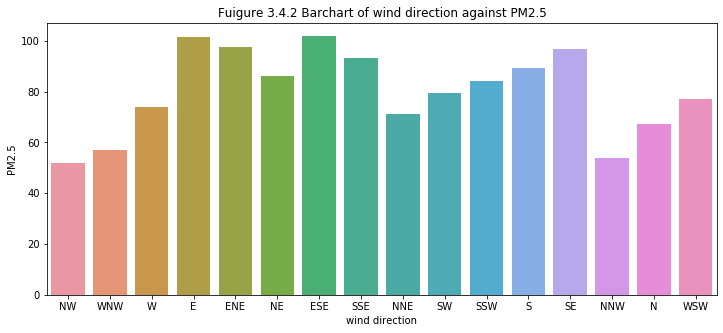

In [33]:
wd_ave = []
wd = air_quality[:]['wd'].unique()
for d in wd:
    wd_ave.append(np.mean(np.array(air_quality[air_quality['wd'] == d]['PM2.5'])))
plt.figure(figsize=(12,5))
sns.barplot(x = wd, y = wd_ave)
plt.title('Fuigure 3.4.2 Barchart of wind direction against PM2.5')
plt.xlabel('wind direction')
plt.ylabel('PM2.5')
plt.show()

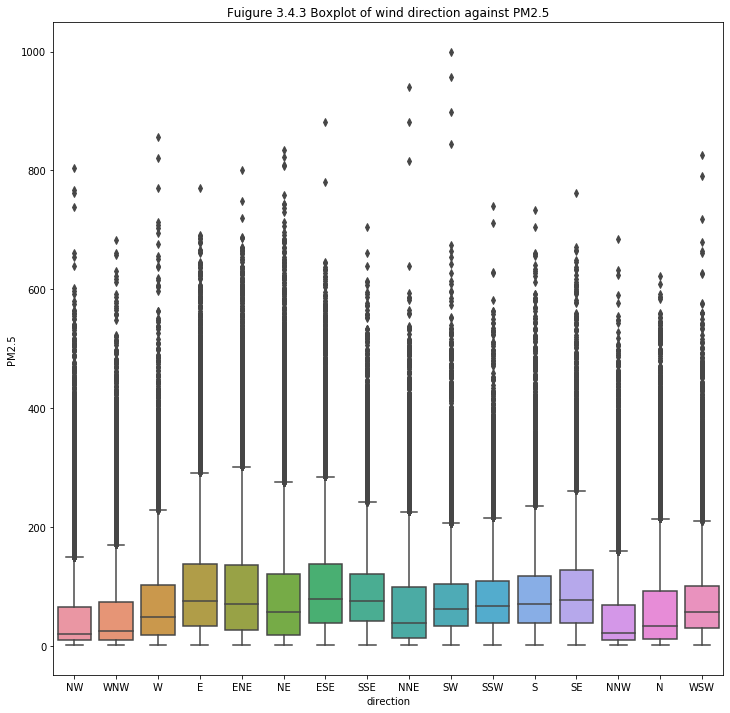

In [34]:
dd = wd[0]
pm = np.array(air_quality[air_quality['wd'] == dd]['PM2.5'])
wd_sample = pd.DataFrame({'PM2.5':pm})
wd_sample['direction'] = np.array([dd for i in range(len(pm))])
for d in wd[1:]:
    s = air_quality[air_quality['wd'] == d]['PM2.5']
    df = pd.DataFrame({'PM2.5':np.array(s)})
    df['direction'] = np.array([d for i in range(len(s))])
    wd_sample = pd.concat([wd_sample, df])
plt.figure(figsize=(12,12))
sns.boxplot(x = 'direction', y = 'PM2.5',data = wd_sample)
plt.title('Fuigure 3.4.3 Boxplot of wind direction against PM2.5')

plt.show()

From the plots above, we can find out that when the wind direction is NW, WNW, NNW, the PM2.5 level is low because they have both a low median and average.

Similarly, when the wind direction is E, ENE, ESE, SSE, SE, the PM2.5 level is high because they have both a high median and average. Basically, if there's east wind, PM2.5 level tend to get higher. We assume the reason is that factories are mainly located east side of Beijing. Thus east wind brings pollution to observation stations.

#### 3.4.3 Explore the Relationship between PM2.5 and Two Categorical Attributes

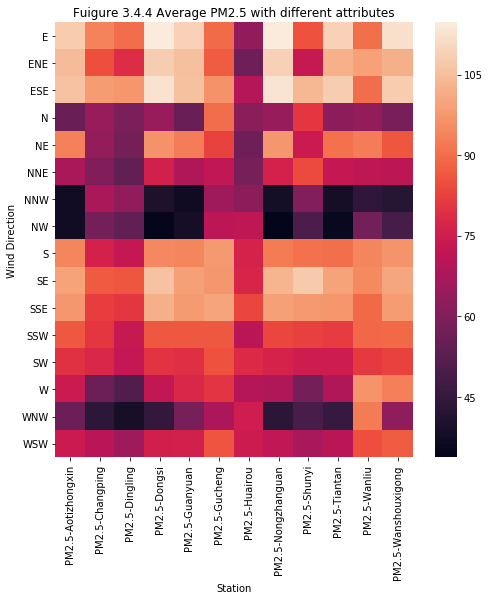

In [35]:
plt.figure(figsize=(8,8))
wind_station = air_quality[:][['wd', 'station', 'PM2.5']]
wind_station_pivot = pd.pivot_table(data=wind_station, index='wd', columns='station', aggfunc=np.mean)
sns.heatmap(wind_station_pivot)
plt.title('Fuigure 3.4.4 Average PM2.5 with different attributes')
plt.xlabel('Station')
plt.ylabel('Wind Direction')
plt.show()

From the plot above, we can see the PM2.5 level of some area with a specific wind direction is very low(eg. NW in Tiantan) as well as a high PM2.5 level of some area with a specific wind direction(eg.SE in Shunyi).

From the plot, we can also see that a relative low PM2.5 level tends to appear along with some wind direction: NW, NNW, WNW while a high PM2.5 level tends to appear along with some wind directions:E, ENE, ESE, SSE, SE which is consistent to our previous result.

Similarly, the PM2.5 level of some area is usually very high: Gucheng, Wanliu and some area relatively low: Shunyi, which is consistent to our previous result.

Comparing these two categorical attributes, the impact of wind over PM2.5 is larger than location

### 3.5 Exploring the Relationship Between Attributes and PCA

#### 3.5.1 Exploring the Relationship Between Attributes

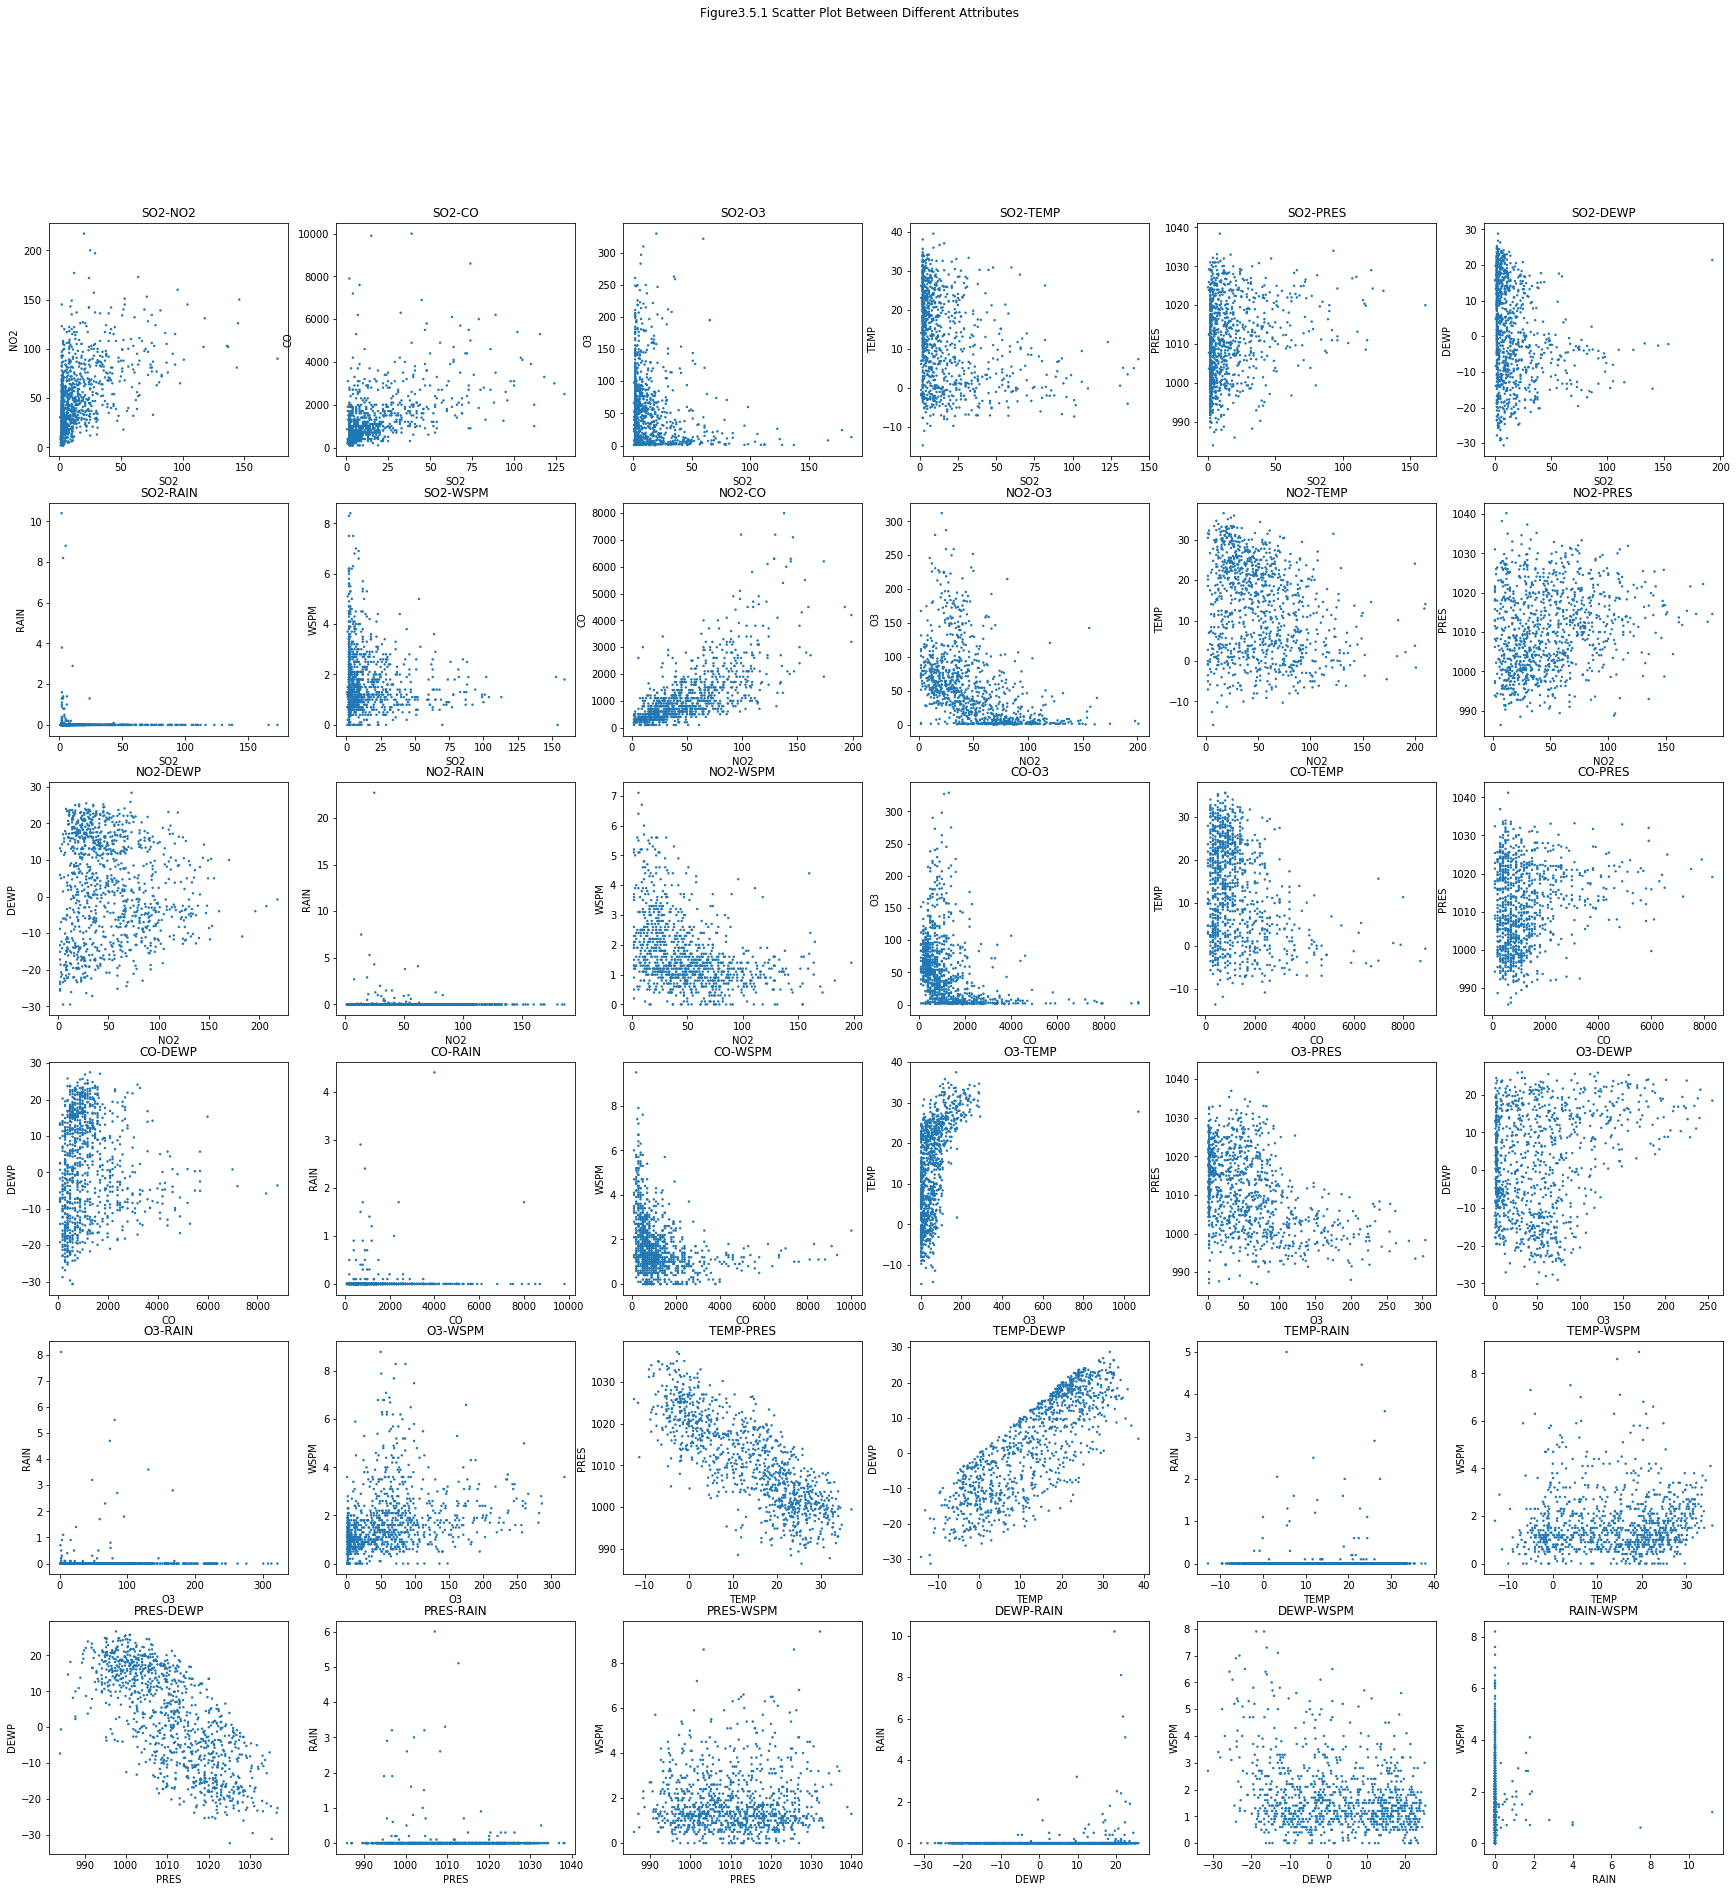

In [36]:
col = air_quality.iloc[:, 5:-4].drop('wd', axis = 1).columns
plt.figure(figsize=(30,30))
size = 1000
k=1
for i in range(len(col)):
    for j in range(i+1, len(col)):
        plt.subplot(6,6,k)
        k = k+1
        data_set = air_quality[[col[i], col[j]]].sample(size)
        att1 = np.array(data_set[col[i]])
        att2 = np.array(data_set[col[j]])
        plt.scatter(att1, att2, s=2*np.ones(att1.shape))
        plt.xlabel(col[i])
        plt.ylabel(col[j])
        plt.title(col[i]+'-'+col[j])
plt.suptitle('Figure3.5.1 Scatter Plot Between Different Attributes')
plt.show()

From the plots above, we can conclude:
1. There are some features which are strongly correlated with each other: NO2 & CO, TEMP & PRES, TEMP & DEWP, DEWP & PRES.


2. There are some features which are weakly correlated with each other.


3. we can keep one of PRES, TEMP, DEWP since they are pairwise strongly correlated.

#### 3.5.2 PCA
Since we cannot apply the concept of `variance` to the categorical attributes, we will only apply PCA over numeric attributes

In [37]:
target_set = air_quality.iloc[:,4:-4].drop('wd', axis = 1).dropna()
pm25_entire = target_set['PM2.5']
target_set.drop('PM2.5', axis = 1, inplace = True)
target_set_reg = (target_set-target_set.mean())/np.sqrt(target_set.var())
u,d,v = np.linalg.svd(target_set_reg, full_matrices=False)
d

array([1204.94537197,  925.00702384,  655.87110325,  647.22638005,
        467.50395951,  417.97896987,  336.98469403,  300.14776973,
        182.7266434 ])

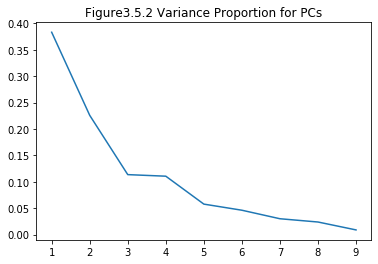

In [38]:
N = sum(d**2)
variance_proportion = d**2/N
sns.lineplot(x = range(1, len(d)+1), y=variance_proportion)
plt.title('Figure3.5.2 Variance Proportion for PCs')
plt.show()

It is obvious that the first two PCs capture the most variance(60%). Let's see the two PCs :

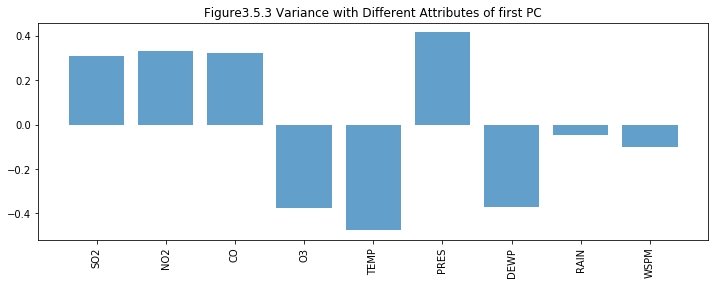

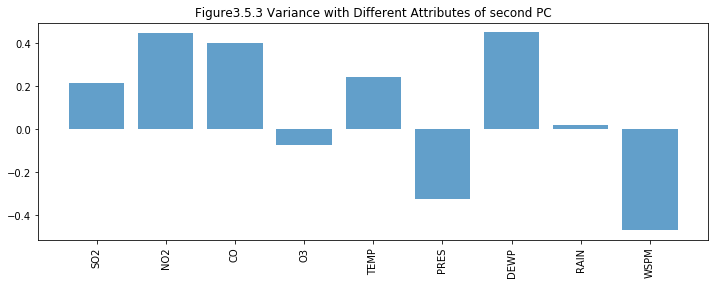

In [39]:
def plot_pc(col_names, vt, k, index):
    plt.bar(col_names, vt[k, :], alpha=0.7)
    plt.xticks(col_names, rotation=90);
    plt.title('Figure3.5.3 Variance with Different Attributes of ' + str(index) + ' PC')
    plt.show()
with plt.rc_context({"figure.figsize": (12, 4)}): 
    plot_pc(list(target_set.columns), v, 0, 'first');
with plt.rc_context({"figure.figsize": (12, 4)}): 
    plot_pc(list(target_set.columns), v, 1, 'second');

#### 3.5.3 Plot points In the New Coordinate

In [40]:
v0 = v[0].T
v1 = v[1].T
new_coordinate = target_set_reg@np.c_[v0, v1]
new_coordinate.columns = ['PC1', 'PC2']
new_coordinate['PM2.5'] = pm25_entire

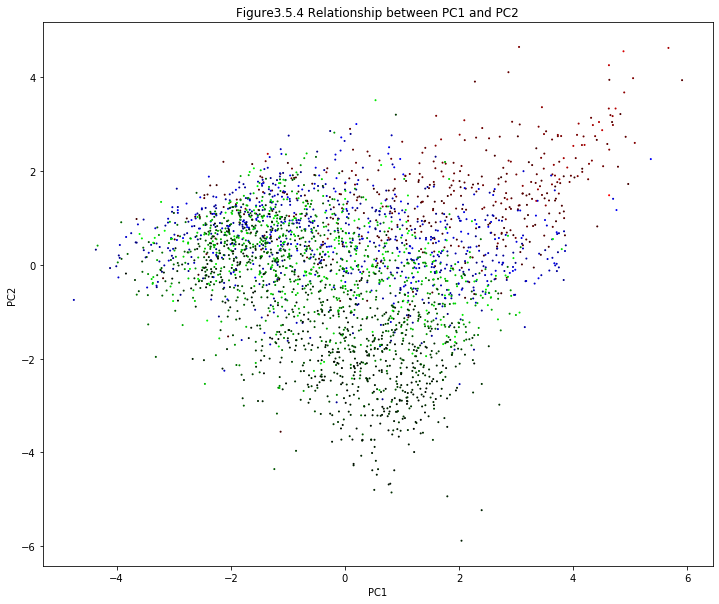

In [41]:
plot_double('PC1', 'PC2',5, 4,  data=new_coordinate, sample_size=3000)

From the plot above, we can see that the color of points change step by step: Points on the upper right of the plot tend to have a high PM2.5 level(red), the PM2.5 level of points in the middle part is lower(blue points), and the points in the lower left part of the plot has the lowest PM2.5 level(green).

Combined with the result of last section, we can conclude that high PM2.5 corresponds to high values both in PC1 and PC2, which has a high value of SO2, NO, CO and low value of O3 and WSPM.

Similarly, low PM2.5 level corresponds to low values in PC2 and not large in PC1, which means that having a high value of PRES, WSPM and a low value of SO2, NO, CO, DEWP

# Description of Methods

## 4. Feature Engineering

Since the data is too massive, let's take a SNS of 42000 (10%) variables.

In [42]:
air_quality = air_quality.sample(42000)

From EDA above, we know that we can drop the two features among TEMP,PRES and DEWP.

In [43]:
air_quality.drop('PRES', axis=1, inplace=True)
air_quality.drop('DEWP', axis=1, inplace=True)

Since we have already represented the station by its latitude and longitude, we can drop the 'station' feature.

In [44]:
air_quality.drop('station', axis=1, inplace=True)

In [45]:
air_quality.shape

(42000, 16)

In [46]:
air_quality.head()

,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,RAIN,wd,WSPM,wd_numeric,station_lon,station_lat
26332,2016,3,2,4,143.0,20.0,85.0,2900.0,7.0000,-1.8,0.0,N,0.5,4,116.310204,39.911589
590,2013,3,25,14,103.0,61.0,5.0,1200.0,81.6102,10.3,0.0,S,2.9,12,116.633396,40.358597
4431,2013,9,1,15,19.0,4.0,6.0,400.0,142.0000,28.8,0.0,NNE,1.6,3,116.621523,40.128292
12591,2014,8,7,15,60.0,14.0,26.0,1100.0,245.0000,32.6,0.0,WSW,2.8,9,116.360962,39.936087
21921,2015,8,31,9,20.0,2.0,11.0,600.0,12.0000,20.5,0.0,ENE,1.3,1,116.633396,40.358597


### Feature Engineering Time
For the time features(year, month and hour), it doesn't make sense if we use discrete variables to represent them. When we are trying to predict the outcome that is dependant on the time of day, a simple model (regression) will suffer the discontinuity at midnight. So we use a 'feature circle' to convert them into sin and cos values. For 'wd' feature, we can also convert it into similar values to represent its directions.

The circles for 'hour' and 'wd' features are as below, circles for other features is almost the same.

Note: we can also use dummy variables here. But since the number of unique values of these features is large, using dummy variables will signicantly increase our model's complexity, which will make it tend to overfit.

<img src="time circle.jpg" width=200> <img src="wind direction.jpg" width=200>

Mapping the time to the circumference of the circle is straightforward.

1. Convert the time to a single number [0, 24) {or [0, 1) , this might be free} so 12:36 could be 12.6 {or 0.525}.
Then stretch that number to cover 360° by multiplying by 15°. {or by 360°}


2. take the Sin and Cos to get the Y and X coordinates.


3. To calculate the average, simply take the average of X and Y independently.


4. To transform back to time using arctan2(E(Y), E(X)), then reverse the transformations (radians to degrees, and un-stretch to 24H )

Define some helper methods to convert the features:

In [47]:
def getHour(hour):
    x = np.sin((90 - hour * 15)/180 * 3.141)
    y = np.cos((90 - hour * 15)/180 * 3.141)
    return x, y

def getMonth(month):
    
    x = np.sin((90 - (month - 1) * 30)/180 * 3.141)
    y = np.cos((90 - (month - 1) * 30)/180 * 3.141)
    return x, y

def getYear(year):
    x = np.sin((90 - (year - 2013) * 72)/180 * 3.141)
    y = np.cos((90 - (year - 2013) * 72)/180 * 3.141)
    return x, y

def getDay(day):
    x = np.sin((90 - (day - 1) * 11.613)/180 * 3.141)
    y = np.cos((90 - (day - 1) * 11.613)/180 * 3.141)
    return x, y

def getWD(wd):
    x = np.sin(( wd * 22.5)/180 * 3.141)
    y = np.cos(( wd * 22.5)/180 * 3.141)
    return x, y

Convert the features:

In [48]:
air_quality['wd_sin'], air_quality['wd_cos'] = getWD(air_quality['wd_numeric'])
air_quality['year_sin'], air_quality['year_cos'] = getYear(air_quality['year'])
air_quality['month_sin'], air_quality['month_cos'] = getMonth(air_quality['month'])
air_quality['hour_sin'], air_quality['hour_cos'] = getHour(air_quality['hour'])
air_quality['day_sin'], air_quality['day_cos'] = getDay(air_quality['day'])

Drop the original features:

In [49]:
air_quality.drop('hour', axis=1, inplace=True)
air_quality.drop('year', axis=1, inplace=True)
air_quality.drop('month', axis=1, inplace=True)
air_quality.drop('wd_numeric', axis=1, inplace=True)
air_quality.drop('wd', axis=1, inplace=True)
air_quality.drop('day', axis=1, inplace=True)

In [50]:
air_quality.shape, air_quality.columns

((42000, 20), Index(['PM2.5', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'RAIN', 'WSPM',
        'station_lon', 'station_lat', 'wd_sin', 'wd_cos', 'year_sin',
        'year_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'day_sin',
        'day_cos'],
       dtype='object'))

## 5.Apply Prediction Methods

### 5.1 Preprocessing

First, generate feature matrix $\mathbf{X}$ and response vector $\mathbf{y}$ .

In [51]:
y = air_quality['PM2.5']
X = air_quality.drop(['PM2.5'], axis=1)

In [52]:
X.head()

,SO2,NO2,CO,O3,TEMP,RAIN,WSPM,station_lon,station_lat,wd_sin,wd_cos,year_sin,year_cos,month_sin,month_cos,hour_sin,hour_cos,day_sin,day_cos
26332,20.0,85.0,2900.0,7.0000,-1.8,0.0,0.5,116.310204,39.911589,1.000000,0.000296,-0.809261,-0.587450,0.499914,0.866075,0.499914,0.866075,0.979478,0.201553
590,61.0,5.0,1200.0,81.6102,10.3,0.0,2.9,116.633396,40.358597,-1.000000,-0.000889,1.000000,0.000296,0.499914,0.866075,-0.866223,-0.499658,0.150854,-0.988556
4431,4.0,6.0,400.0,142.0000,28.8,0.0,1.6,116.621523,40.128292,0.923794,0.382889,1.000000,0.000296,-0.500428,-0.865778,-0.707421,-0.706792,1.000000,0.000296
12591,14.0,26.0,1100.0,245.0000,32.6,0.0,2.8,116.360962,39.936087,-0.382067,-0.924134,0.308961,0.951075,-0.866223,-0.499658,-0.707421,-0.706792,0.347233,0.937779
21921,2.0,11.0,600.0,12.0000,20.5,0.0,1.3,116.633396,40.358597,0.382615,0.923908,-0.808912,0.587929,-0.866223,-0.499658,-0.707002,0.707212,0.979369,-0.202082


Define some helper methods:

In [53]:
def rmse(actual_y, predicted_y):
    """
    Args:
        predicted_y: an array of the prediction from the model
        actual_y: an array of the groudtruth label
        
    Returns:
        The root mean square error between the prediction and the groudtruth
    """
    actual_y = np.array(actual_y).reshape(1,-1)
    predicted_y = np.array(predicted_y).reshape(1,-1)
    return np.sqrt(np.mean((actual_y - predicted_y) ** 2))

from sklearn.model_selection import KFold


def compute_CV_error(model, X_train, Y_train):
    '''
    Split the training data into 4 subsets.
    For each subset, 
        fit a model holding out that subset
        compute the MSE on that subset (the validation set)
    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 

    Return:
        the average validation MSE for the 4 splits.
    '''
    kf = KFold(n_splits=4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx,:], X_train.iloc[valid_idx,:]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid, model.predict(split_X_valid))


        validation_errors.append(error)
        
    return np.mean(validation_errors)


From above, we can tell that data is not normalized. However, it should be normalized because this can make the data measured in the same units which can avoid the unwanted mathematical variations which can't be eliminated during analysis.

In [54]:
X_normalized = (X - X.mean())/np.std(X)

Split the data into training set and testing set.

In [55]:
train, test = sklearn.model_selection.train_test_split(
    X_normalized, train_size=0.8, test_size=0.2, random_state=42)
y_train, y_test = sklearn.model_selection.train_test_split(
    y, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)
train, test = pd.DataFrame(train), pd.DataFrame(test)
y_train, y_test = pd.DataFrame(y_train), pd.DataFrame(y_test)

Train: (33600, 19) Test: (8400, 19)


### 5.2 Fitting models

Create a dataFrame to record the evalution of the models:

In [56]:
evaluation = pd.DataFrame(columns=['method', 'train_RMSE', 'CV_RMSE', 'fitting_time']) 
method = []
CV_RMSE = []
train_RMSE = []
running_time = []

#### 5.2.1 Linear Regression
Let's assume the true model is linear, use Linear Regression:

In [57]:
starttime = time.time()
linear_model = lm.LinearRegression().fit(train, y_train)
endtime = time.time()
lm_fitting_time = endtime - starttime

lm_train_RMSE = rmse(linear_model.predict(train),y_train )
lm_CV_RMSE = compute_CV_error(linear_model, train, y_train)

print(f"training RMSE is {lm_train_RMSE}")
print(f"CV RMSE is {lm_CV_RMSE}")

method.append('LR')
CV_RMSE.append(lm_CV_RMSE)
train_RMSE.append(lm_train_RMSE)
running_time.append(lm_fitting_time)

training RMSE is 45.506628276164534
CV RMSE is 45.549500613418374


From above, we can tell that both the training and CV RMSEs are relatively large. Therefore, we know that the true model is not linear.

Besides, since the training RMSE and CV RMSE are very close, the overfitting issue doen't exist here and there is no point to use regularization.

#### 5.2.2 KNN
Let's use a non-parametric method KNN :

In [58]:
starttime = time.time()
kNN_model = KNeighborsRegressor(weights='uniform').fit(train, y_train)
endtime = time.time()
kNN_fitting_time = endtime - starttime

kNN_train_RMSE = rmse(kNN_model.predict(train),y_train )
kNN_CV_RMSE = compute_CV_error(kNN_model, train, y_train)

print(f"training RMSE is {kNN_train_RMSE}")
print(f"CV RMSE is {kNN_CV_RMSE}")

method.append('kNN')
CV_RMSE.append(kNN_CV_RMSE)
train_RMSE.append(kNN_train_RMSE)
running_time.append(kNN_fitting_time)

training RMSE is 32.582580709856074
CV RMSE is 42.242789470842276


From above, we can tell that kNN method performs better than linear regression. However, it has relatively large computational cost. 

Besides, it suffers from the curse of high dimensionality, which makes its performance not that good.

#### 5.2.3 Random Forest
Finally, let's use Random Forest Method:

In [59]:
starttime = time.time()

random_forest_model = ensemble.RandomForestRegressor(random_state = 42, n_estimators = 20).fit(train, y_train)
endtime = time.time()
random_forest_fitting_time = endtime - starttime

random_forest_train_RMSE = rmse(random_forest_model.predict(train),y_train )
random_forest_CV_RMSE = compute_CV_error(random_forest_model, train, y_train)

print(f"training RMSE is {random_forest_train_RMSE}")
print(f"CV RMSE is {random_forest_CV_RMSE}")
random_forest_model.score(train, y_train), random_forest_model.score(test, y_test)

method.append('random_forest')
CV_RMSE.append(random_forest_CV_RMSE)
train_RMSE.append(random_forest_train_RMSE)
running_time.append(random_forest_fitting_time)

training RMSE is 13.99734757284925
CV RMSE is 35.92740807839362


From above, we can tell random forest method performs best in our data.

# 6. Summarize and Interpret results

In [60]:
evaluation['method'] = method
evaluation['train_RMSE'] = train_RMSE
evaluation['CV_RMSE'] = CV_RMSE
evaluation['fitting_time'] = running_time

In [61]:
evaluation

,method,train_RMSE,CV_RMSE,fitting_time
0,LR,45.506628,45.549501,0.011971
1,kNN,32.582581,42.242789,0.972390
2,random_forest,13.997348,35.927408,3.912079


Text(0.5, 1.0, 'Figure6.1 Train_RMSE of Different Methods')

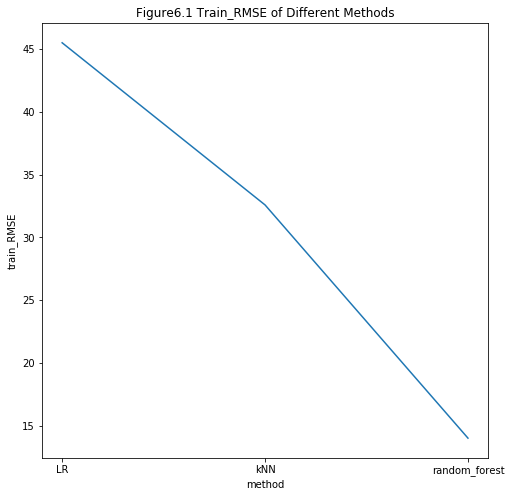

In [62]:
plt.figure(figsize = (8,8))
sns.lineplot(x = 'method', y='train_RMSE', data = evaluation)
plt.title('Figure6.1 Train_RMSE of Different Methods')

Text(0.5, 1.0, 'Figure6.2 CV_RMSE of Different Methods')

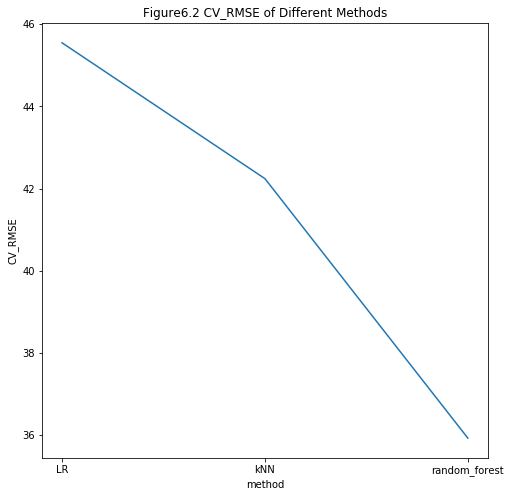

In [63]:
plt.figure(figsize = (8,8))
sns.lineplot(x = 'method', y='CV_RMSE', data = evaluation)
plt.title('Figure6.2 CV_RMSE of Different Methods')

Text(0.5, 1.0, 'Figure6.3 Computation Time of Different Methods')

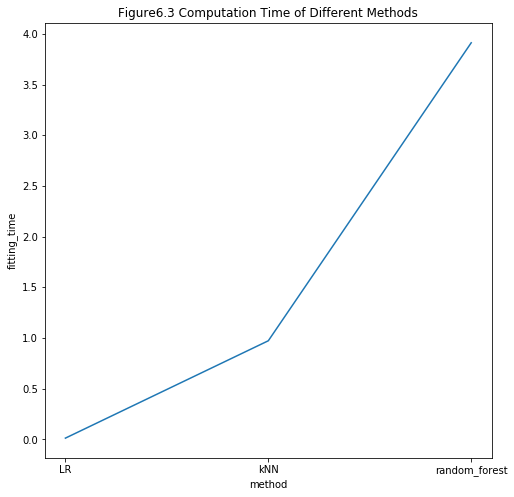

In [64]:
plt.figure(figsize = (8,8))
sns.lineplot(x = 'method', y='fitting_time', data = evaluation)
plt.title('Figure6.3 Computation Time of Different Methods')

From the visualization above, we can see that random forest method performs best, but it has high computational cost. There is a trade-off between performance and fitting time.

Since our original data set is massive, the computational cost may be an issue that we need to consider.

Finally, let's use testing data to evaluate our models.

In [65]:
print(f"testing score of LR method is {linear_model.score(test, y_test)}")
print(f"testing score of kNN method is {kNN_model.score(test, y_test)}")
print(f"testing score of Random Forest method is {random_forest_model.score(test, y_test)}")

testing score of LR method is 0.6679802192550417
testing score of kNN method is 0.7235920280219825
testing score of Random Forest method is 0.7926120019050238


# Conclusion

## 7. Describe Discoveries And Future work
### 7.1 Discoveries
1. The PM2.5 level of summer is obviously lower than that of winter. 
2. The PM2.5 level increases from May to July and then decreases in August. 
3. The PM2.5 level changes a lot during the 24 hours of a day. It reaches its peak on 11 PM and the lowest value is achieved on 6 AM
4. There does exist an approximate linear relationship between PM2.5 and NO2/CO
5. With low wind speed and relative dry environment, PM2.5 level tends to be high.
6. With a high level of SO2 in the atmosphere, PM2.5 level tends to be high. What's more, with a high level of SO2, if O3 level is high, PM2.5 level is generally very high
7. With low wind speed and low temperature, PM2.5 level tends to be higher.
8. The PM2.5 level of the upper right corner of Beijing is relatively low since the red dots which represent high PM2.5 records are relatively sparse and green dots which represent low PM2.5 records are relatively dense. Similarly, the PM2.5 level of the lower left corner of Beijing is relatively high
9. When the wind direction is NW, WNW, NNW, the PM2.5 level is low because they have both a low median and average. Similarly, when the wind direction is E, ENE, ESE, SSE, SE, the PM2.5 level is high because they have both a high median and average.
10. The impact of wind over PM2.5 is larger than location
11. We can divide the set of features into two groups. The first one is chemical features which includes the features related to gas: CO, SO2, O3,NO2 .The second one is physical features which includes other features. It turns out that intra-group features tend to be more correlated to each other than inter-group features with only one exception: RAIN, which is nearly uncorrelated to all other features.

### 7.2 Future work
1. There are still more we can do in the feature engineering part. For instance, we can try to combine some features together(NO and SO2 may be combined to a better feature to work with). 
2. We can try other predicting methods like CNN to fit a better model.